# eQTL Inference Analysis: Comparing MultiGATE Cross-Modality Attention Scores

## Overview
This notebook performs comparative analysis of cis-regulatory predictions by comparing MultiGATE's cross-modality attention scores against traditional eQTL (expression Quantitative Trait Loci) inference methods. The analysis integrates RNA-seq, ATAC-seq, and genomic reference data to evaluate different computational approaches for predicting gene regulatory relationships.

## Analysis Methods Compared
- **MultiGATE Cross-Modality Attention**: Attention scores from MultiGATE model
- **Spearman Correlation**: Gene-peak expression correlations 
- **LASSO Regression**: Sparse linear regression for regulatory inference
- **Cicero**: Chromatin accessibility co-accessibility predictions

## Workflow Overview
1. **Data Loading and Preprocessing**: Load and prepare multi-omics datasets
2. **Genomic Annotation**: Annotate genomic coordinates and map features  
3. **Distance Graph Construction**: Build genomic distance-based connectivity networks
4. **Method Implementation**: Apply different regulatory inference approaches
5. **eQTL Validation**: Compare predictions against known eQTL associations
6. **Performance Evaluation**: Generate ROC curves and comparative metrics


# 1. Environment Setup and Library Imports

## Purpose
Import all necessary libraries for multi-omics data processing, machine learning, genomics analysis, and visualization.

## Libraries Used
- **Data Processing**: pandas, numpy, scipy
- **Single-cell Analysis**: scanpy, anndata
- **Machine Learning**: scikit-learn
- **Genomics**: custom genomics module
- **Network Analysis**: networkx
- **Visualization**: matplotlib, seaborn


In [1]:
# Core data processing libraries
import pandas as pd
import utils
import numpy as np
import scipy

In [2]:
# Single-cell analysis and data structures
import anndata
from anndata import AnnData
import scanpy as sc
import anndata as ad

In [3]:
# Progress tracking
from tqdm.auto import tqdm


In [4]:

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns   
%matplotlib inline


In [5]:
# Genomics analysis and machine learning
import genomics
import sklearn
import sklearn.decomposition

In [6]:
# Network analysis for graph-based methods
import networkx as nx
from networkx.algorithms.bipartite import biadjacency_matrix

In [7]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [8]:
# File system operations and output directory setup
import os
import re

# Set up output directory for results
PATH='results_eqtl_only_20250613'
os.makedirs(PATH, exist_ok=True)

In [9]:
# Define color palette for method comparison visualizations
palette = {}
palette["Cicero"] = "#8C564B"
palette["Spearman"] = "#17BECF" 
palette["LASSO"] = "#BCBD22"

# 2. Multi-Omics Data Loading and Preprocessing

## Purpose
Load and prepare RNA-seq and ATAC-seq datasets for comparative regulatory analysis.

## Data Sources
- **RNA-seq**: Human transcriptome expression data
- **ATAC-seq**: Chromatin accessibility profiles with LSI dimensionality reduction
- **Reference Annotations**: GTF files for genomic coordinate mapping


## 2.1 Multi-Omics Data Loading

### Load RNA-seq and ATAC-seq Data Files

In [10]:
# Define file paths for RNA-seq and ATAC-seq datasets
filename_rna="./ReferenceData/Human_RNA.h5ad"
filename_atac='./ReferenceData/Human_ATAC_lsi.h5ad'

In [11]:
# Load the data files into AnnData objects
rna=anndata.read(filename_rna)
atac=anndata.read(filename_atac)

### 2.2 Gene Annotation and Genomic Coordinates

In [12]:
# Extract gene names from RNA data for annotation
var_by=rna.var_names

# Load GTF annotation file for gene coordinates
gtf = './ReferenceData/gencode.v25.chr_patch_hapl_scaff.annotation.gtf.gz'
gtf_by = "gene_name"
COLUMNS = pd.Index(["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"])

loaded = pd.read_csv(gtf, sep="\t", header=None, comment="#")
loaded.columns = COLUMNS[:loaded.shape[1]]
loaded = loaded.query("feature == 'gene'")

# Extract information from attribute column
pattern = re.compile(r'([^\s]+) "([^"]+)";')
splitted = pd.DataFrame.from_records(np.vectorize(lambda x: {
    key: val for key, val in pattern.findall(x)
})(loaded["attribute"]), index=loaded.index)
loaded = loaded.assign(**splitted)
loaded = loaded.sort_values("seqname").drop_duplicates(subset=[gtf_by], keep="last")

# Create BED format DataFrame for genes
bed_df = pd.DataFrame(loaded, copy=True).loc[:, ("seqname", "start", "end", "score", "strand")]
bed_df.insert(3, "name", np.repeat(".", len(bed_df)) if gtf_by is None else loaded[gtf_by])
bed_df["start"] -= 1  # Convert to 0-based coordinates
bed_df.columns = ("chrom", "chromStart", "chromEnd", "name", "score", "strand")

# Adjust data types
for item in bed_df.columns:
    if item in ("chromStart", "chromEnd"):
        bed_df[item] = bed_df[item].astype(int)
    else:
        bed_df[item] = bed_df[item].astype(str)

# Merge data and preserve strand information
gene_df = pd.concat([
    pd.DataFrame(bed_df),
    pd.DataFrame(loaded).drop(columns=COLUMNS)  # Use only split attributes
], axis=1).set_index(gtf_by).reindex(var_by)

# Ensure strand column is included
gene_df = gene_df[['chrom', 'chromStart', 'chromEnd', 'strand']]
gene_df.dropna(inplace=True)
gene_df.head()

,chrom,chromStart,chromEnd,strand
LINC01128,chr1,825137.0,859446.0,+
NOC2L,chr1,944203.0,959309.0,-
SDF4,chr1,1216907.0,1232031.0,-
UBE2J2,chr1,1253908.0,1273885.0,-
ACAP3,chr1,1292375.0,1309609.0,-


In [13]:
# Filter genes that have chromosome information
rna=rna[:,gene_df.index]

In [14]:
# Add genomic coordinate information to RNA data
rna.var['chrom'] = gene_df.loc[rna.var_names, 'chrom']
rna.var['chromStart'] = gene_df.loc[rna.var_names, 'chromStart']
rna.var['chromEnd'] = gene_df.loc[rna.var_names, 'chromEnd']
rna.var['strand'] = gene_df.loc[rna.var_names, 'strand']

In [15]:
atac.var_names.str.split('-', expand=True).to_frame(index=False)

,0,1,2
0,chr1,191019,191845
1,chr1,629518,630418
2,chr1,631198,631975
3,chr1,633583,634481
4,chr1,778315,779209
...,...,...,...
28265,GL000218.1,53309,54212
28266,GL000218.1,62719,63633
28267,GL000218.1,97012,97847
28268,KI270711.1,8063,8911


In [16]:
# Extract chromosome name, start and end positions for ATAC peaks
chrom_info = atac.var_names.str.split('-', expand=True).to_frame(index=False)
chrom_info.columns = ['chrom', 'chromStart', 'chromEnd']

# Convert string positions to integers
chrom_info['chromStart'] = chrom_info['chromStart'].astype(int)
chrom_info['chromEnd'] = chrom_info['chromEnd'].astype(int)
chrom_info

,chrom,chromStart,chromEnd
0,chr1,191019,191845
1,chr1,629518,630418
2,chr1,631198,631975
3,chr1,633583,634481
4,chr1,778315,779209
...,...,...,...
28265,GL000218.1,53309,54212
28266,GL000218.1,62719,63633
28267,GL000218.1,97012,97847
28268,KI270711.1,8063,8911


In [17]:

# Set atac.var_names as index for chrom_info
chrom_info.index = atac.var_names

# Ensure chrom_info index matches atac.var index
if chrom_info.index.equals(atac.var.index):
    # Add chrom_info to atac.var
    atac.var[['chrom', 'chromStart', 'chromEnd']] = chrom_info
else:
    print("Index mismatch! Cannot add chromosome information!")

# Check updated atac.var
atac.var.head()

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm,chrom,chromStart,chromEnd
chr1-191019-191845,87,0.0624,0.060530,96.52,156.0,5.056246,87,True,19775.0,0.0624,0.119354,0.971376,chr1,191019,191845
chr1-629518-630418,716,0.8208,0.599276,71.36,2052.0,7.627058,716,True,1845.0,0.8208,2.808211,1.091278,chr1,629518,630418
chr1-631198-631975,78,0.0516,0.050313,96.88,129.0,4.867535,78,True,26762.0,0.0516,0.092174,0.913984,chr1,631198,631975
chr1-633583-634481,2387,23.4536,3.196777,4.52,58634.0,10.979087,2387,True,23585.0,23.4536,688.815373,0.948374,chr1,633583,634481
chr1-778315-779209,184,0.1468,0.136975,92.64,367.0,5.908083,184,True,14116.0,0.1468,0.306172,0.998834,chr1,778315,779209


In [18]:
rna.obsm['X_pca'] = sklearn.decomposition.PCA(n_components=20).fit_transform(rna.X.toarray())

In [19]:
# Alternative PCA implementation (commented out)
# from sklearn.decomposition import PCA
# pca = PCA(n_components=20)
# rna.obsm['X_pca'] = pca.fit_transform(rna.X.toarray())


# 3. eQTL Reference Data Integration

## Purpose  
Load and process eQTL reference data for validation and benchmarking of regulatory predictions.

## Data Processing Steps
- Load gene ID mapping for annotation consistency
- Import eQTL associations from reference databases  
- Filter datasets to common genes present in both RNA-seq and eQTL data
- Load MultiGATE cross-modality attention scores for comparison


In [20]:
# Load gene ID mapping for consistent annotation across datasets
import pickle
with open('gene_id_mapping.pickle', 'rb') as handle:
    gene_id_mapping = pickle.load(handle)

In [21]:
# Load eQTL reference data and map gene identifiers
eqtl = genomics.read_bed("./ReferenceData/human_eqtl.bed.gz.bed.gz") 
eqtl["name"] = eqtl["name"].map(genomics.ens_trim_version).map(gene_id_mapping)
eqtl = genomics.Bed(eqtl.df.dropna(subset=["name"]))


In [22]:
# Filter RNA-seq data to genes present in eQTL reference dataset
rna_genes = set(rna.var_names)
eqtl_genes = set(eqtl["name"])
rna = rna[:, list(rna_genes.intersection(eqtl_genes))]

### 3.1 Load MultiGATE Cross-Modality Attention Scores

In [23]:
# Load MultiGATE cross-modality attention scores (gene-peak links)
link_with_name=pd.read_csv('/lustre/project/Stat/s1155077016/Spatial_multi-omics_data/Human/output/mouse_gene2link_withGeneName_0113.links',sep='\t',header=None)
link_with_name= link_with_name.rename(columns={0: "Gene", 4:"Peak"})
link_with_name['Peak'] = link_with_name['Peak'].str.replace('-', ':', n=1, regex=True)
link_with_name["Gene"] = link_with_name["Gene"].str.upper()
link_with_name

,Gene,1,2,3,Peak,5,6,7,8
0,A2M,chr12,9067663,9116229,chr12:9115492-9116400,chr12,9115492,9116400,0.324064
1,A2M,chr12,9067663,9116229,chr12:9117970-9118894,chr12,9117970,9118894,0.324064
2,A2M,chr12,9067663,9116229,chr12:9064332-9065050,chr12,9064332,9065050,0.027808
3,ABCA1,chr9,104781001,104928237,chr9:104926201-104927103,chr9,104926201,104927103,0.320709
4,ABCA1,chr9,104781001,104928237,chr9:104968056-104968871,chr9,104968056,104968871,0.055020
...,...,...,...,...,...,...,...,...,...
16342,ZSWIM7,chr17,15976559,15999717,chr17:15965296-15966096,chr17,15965296,15966096,0.060454
16343,ZSWIM7,chr17,15976559,15999717,chr17:15944636-15945512,chr17,15944636,15945512,0.054500
16344,ZZEF1,chr17,4004444,4143020,chr17:4142763-4143403,chr17,4142763,4143403,0.326861
16345,ZZEF1,chr17,4004444,4143020,chr17:4143520-4144206,chr17,4143520,4144206,0.326861


In [24]:
# Reorganize MultiGATE results with standardized column names
df2=link_with_name.copy()
df2.rename(columns={5:'Chrm2',6:'Start2',7:'End2',1:'Chrm1',2:'Start1',3:'End1',8:'score'},inplace=True)

In [25]:
# Calculate genomic distance between gene and peak
df2['distance']= (df2['Start2']-df2['Start1']).abs()

In [26]:
# Define distance bins for analysis (in kilobases)
DIST_BINS = [0, 25, 50, 75, 100, 125, 150]  # in KB

In [27]:
# Assign distance bins to each gene-peak pair
df2["dist_bin"] = utils.make_dist_bins(df2["distance"], bins=DIST_BINS)

In [28]:
# Normalize MultiGATE attention scores to 0-1 range for fair comparison
df2['score'] = df2['score'].apply(lambda x: min(1, ( x- df2['score'].min()) / (df2['score'].max() - df2['score'].min())))


In [29]:
df2

,Gene,Chrm1,Start1,End1,Peak,Chrm2,Start2,End2,score,distance,dist_bin
0,A2M,chr12,9067663,9116229,chr12:9115492-9116400,chr12,9115492,9116400,0.642628,47829,25-50 kb
1,A2M,chr12,9067663,9116229,chr12:9117970-9118894,chr12,9117970,9118894,0.642628,50307,50-75 kb
2,A2M,chr12,9067663,9116229,chr12:9064332-9065050,chr12,9064332,9065050,0.040855,3331,0-25 kb
3,ABCA1,chr9,104781001,104928237,chr9:104926201-104927103,chr9,104926201,104927103,0.635813,145200,125-150 kb
4,ABCA1,chr9,104781001,104928237,chr9:104968056-104968871,chr9,104968056,104968871,0.096131,187055,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16342,ZSWIM7,chr17,15976559,15999717,chr17:15965296-15966096,chr17,15965296,15966096,0.107168,11263,0-25 kb
16343,ZSWIM7,chr17,15976559,15999717,chr17:15944636-15945512,chr17,15944636,15945512,0.095074,31923,25-50 kb
16344,ZZEF1,chr17,4004444,4143020,chr17:4142763-4143403,chr17,4142763,4143403,0.648310,138319,125-150 kb
16345,ZZEF1,chr17,4004444,4143020,chr17:4143520-4144206,chr17,4143520,4144206,0.648310,139076,125-150 kb


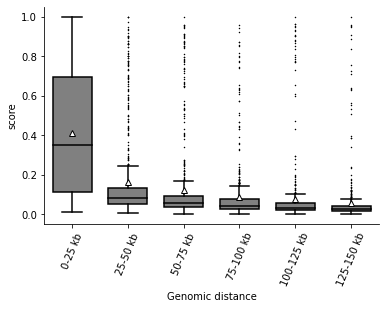

In [30]:
ax = sns.boxplot(
    x="dist_bin", y="score", data=df2.sample(frac=0.3),
    color="grey", width=0.7, showmeans=True,
    meanprops=dict(marker="^", markerfacecolor="white", markeredgecolor="black"),
    boxprops=dict(edgecolor="black"), medianprops=dict(color="black"),
    whiskerprops=dict(color="black"), capprops=dict(color="black"),
    flierprops=dict(marker=".", markerfacecolor="black", markeredgecolor="none", markersize=3)
)
ax.set_xlabel("Genomic distance")
ax.set_ylabel("score")
for item in ax.get_xticklabels():
    item.set_rotation(67.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_figure().savefig(f"{PATH}/dist_binned_score.pdf")

# 4. Distance-Based Regulatory Network Construction

## Purpose
Build genomic distance-based connectivity graphs to define potential gene-regulatory element relationships.

## Methodology
- Create distance-constrained graphs between gene promoters and ATAC-seq peaks
- Apply distance-based decay functions to weight regulatory potential  
- Establish 150kb maximum distance threshold for cis-regulatory interactions


## 4.1 Gene-Peak Distance Graph


In [31]:
# Create genomic coordinate objects for genes and peaks
genes = genomics.Bed(rna.var.assign(name=rna.var_names))
peaks = genomics.Bed(atac.var.assign(name=atac.var_names))

# Define gene transcription start sites and promoter regions (2kb upstream)
tss = genes.strand_specific_start_site()
promoters = tss.expand(2000, 0)

In [32]:
# Build distance-constrained graph with 150kb maximum distance threshold
# Apply power decay weighting function based on genomic distance
dist_graph = genomics.window_graph(
    promoters, peaks, 150000,
    attr_fn=lambda l, r, d: { 
        "dist": abs(d),
        "weight": genomics.dist_power_decay(abs(d)),
        "type": "dist"
    }
)


In [33]:
dist_graph = nx.DiGraph(dist_graph)
dist_graph.number_of_edges()

9621

# 5. Spearman Correlation Analysis

## Purpose
Compute Spearman rank correlations between gene expression and chromatin accessibility as a baseline regulatory inference method.

## Methodology
- Apply metacell aggregation to reduce noise and computational complexity
- Calculate correlations within distance-constrained gene-peak pairs
- Use PCA-transformed expression data for improved signal detection


## Spearman correlation 

In [34]:
from utils import metacell_corr

In [35]:

corr = biadjacency_matrix(
    metacell_corr(
        rna, atac, "X_pca", n_meta=100, skeleton=dist_graph, method="spr"
    ), genes.index, peaks.index, weight="corr", dtype=np.float32
)

Clustering metacells...


WARNING clustering 2500 points to 100 centroids: please provide at least 3900 training points


Computing correlation...


In [36]:
window = biadjacency_matrix(
    dist_graph, genes.index, peaks.index, weight=None, dtype=np.float32
).tocoo()

In [37]:
dist = biadjacency_matrix(dist_graph, genes.index, peaks.index, weight="dist", dtype=np.float32)

In [38]:
dist = window.multiply(dist.toarray())

In [39]:
corr = window.multiply(corr.toarray())

In [40]:
df_corr=pd.DataFrame({
    "corr":corr.data,
    "dist":dist.data.astype(int),
})

In [41]:
non_zero_rows = dist.row
non_zero_cols = dist.col


df_corr['Gene'] = [genes.index[row] for row in non_zero_rows]
df_corr['Peak'] = [peaks.index[col] for col in non_zero_cols]



In [42]:
df_corr['Peak'] = df_corr['Peak'].str.replace('-', ':', n=1, regex=True)
df_corr

,corr,dist,Gene,Peak
0,-0.000998,0,PPDPF,chr20:63520187-63521065
1,-0.213281,16902,PPDPF,chr20:63537625-63538530
2,-0.127565,105934,PPDPF,chr20:63626657-63627600
3,-0.067906,120776,PPDPF,chr20:63641499-63642362
4,-0.142458,132253,PPDPF,chr20:63652976-63653903
...,...,...,...,...
9616,0.125040,0,MIPEP,chr13:23888975-23889801
9617,0.107152,88032,MIPEP,chr13:23979450-23980037
9618,0.091456,101176,MIPEP,chr13:23992594-23993519
9619,0.065928,147112,MIPEP,chr13:24038530-24039306


In [43]:
# Add eQTL validation information to correlation results


In [44]:
eqtl_graph = genomics.window_graph(
    eqtl, peaks, 0, left_sorted=True,
    attr_fn=lambda l, r, d: {
        "weight": 1.0,
        "type": "eqtl"
    }
)
eqtl_graph = nx.DiGraph(eqtl_graph)
eqtl_graph.number_of_edges()

4899

In [45]:
eqtl_genes = pd.read_table(
    "./ReferenceData/Brain_Hippocampus.v8.signif_variant_gene_pairs.txt.gz", usecols=["gene_id"] 
)["gene_id"].map(genomics.ens_trim_version).map(gene_id_mapping).dropna()
eqtl_genes = set(eqtl_genes)
rna.var["in_eqtl"] = [item in eqtl_genes for item in rna.var_names]
rna.var["in_eqtl"].sum()

1471

In [46]:

eqtl_links = eqtl.df.iloc[:, :4].merge(tss.df.iloc[:, :4], how="left", on="name").assign(score=1)
eqtl_links = eqtl_links.query("chrom_x == chrom_y")
eqtl_links["name"] = eqtl_links.pop("name")
eqtl_links.to_csv(f"{PATH}/eqtl.annotated_links", sep="\t", index=False, header=False)

In [47]:
eqtl = biadjacency_matrix(eqtl_graph, genes.index, peaks.index, weight=None, dtype=np.float32)

In [48]:
eqtl = window.multiply(eqtl.toarray())

In [49]:
df_corr['eqtl']=eqtl.data.astype(bool)

In [50]:
df_corr["eqtl"] = pd.Categorical(df_corr["eqtl"], categories=[False, True])


## Sparse regression

In [51]:
from utils import metacell_regr

In [52]:

regr,coef = metacell_regr(
    rna, atac, "X_pca", n_meta=150, skeleton=dist_graph.reverse(),
    model="Lasso", alpha=0.01, random_state=0  # Optimized for AUROC and AP
)

Clustering metacells...
Computing regression...


WARNING clustering 2500 points to 150 centroids: please provide at least 5850 training points


metacell_regr:   0%|          | 0/1438 [00:00<?, ?it/s]

In [53]:
regr = biadjacency_matrix(
    regr, peaks.index, genes.index, weight="regr", dtype=np.float32
).T

# 7. Cicero Co-accessibility Integration

## Purpose
Integrate Cicero-derived chromatin co-accessibility scores as an comparing method for regulatory prediction.

## Methodology  
- Load pre-computed Cicero co-accessibility scores between chromatin regions
- Map co-accessible peaks to gene promoters for regulatory inference
- Compare Cicero predictions against other methods


In [54]:
df_corr['regr']=regr.data

## Cicero

In [55]:
cicero = pd.read_csv("./ReferenceData/cicero_conns11.csv.gz").dropna().query("coaccess != 0")
cicero["Peak1"] = cicero["Peak1"].str.split("_").map(lambda x: f"{x[0]}:{x[1]}-{x[2]}")
cicero["Peak2"] = cicero["Peak2"].str.split("_").map(lambda x: f"{x[0]}:{x[1]}-{x[2]}")
cicero.head()

,Peak1,Peak2,coaccess
6,GL000195.1:130325-131217,GL000195.1:30323-31231,0.075668
7,GL000195.1:130325-131217,GL000195.1:32348-33198,0.013569
8,GL000195.1:130325-131217,GL000195.1:52919-53777,0.000572
10,GL000195.1:30323-31231,GL000195.1:32348-33198,0.179320
11,GL000195.1:30323-31231,GL000195.1:52919-53777,0.007554


In [56]:
peak_gene_mapping = genomics.window_graph(peaks, promoters, 0)
peak_gene_mapping = nx.DiGraph(peak_gene_mapping)
peak_gene_mapping = nx.to_pandas_edgelist(
    peak_gene_mapping, source="Peak1", target="Gene"
).loc[:, ["Peak1", "Gene"]]

In [57]:
cicero['Peak1'] = cicero['Peak1'].str.replace(':', '-', n=1, regex=True)
cicero['Peak2'] = cicero['Peak2'].str.replace(':', '-', n=1, regex=True)
cicero = pd.merge(cicero, peak_gene_mapping)
cicero

,Peak1,Peak2,coaccess,Gene
0,chr10-100286223-100287065,chr10-100185571-100186414,-0.000847,BLOC1S2
1,chr10-100286223-100287065,chr10-100229051-100229899,0.002908,BLOC1S2
2,chr10-100286223-100287065,chr10-100340788-100341665,0.109125,BLOC1S2
3,chr10-100286223-100287065,chr10-100342179-100342997,-0.000555,BLOC1S2
4,chr10-100286223-100287065,chr10-100346539-100347359,0.004144,BLOC1S2
...,...,...,...,...
7407,chrX-49199744-49200657,chrX-49163551-49164437,-0.007142,SYP
7408,chrX-49199744-49200657,chrX-49166013-49166890,0.001039,SYP
7409,chrX-49199744-49200657,chrX-49190768-49191694,0.051527,SYP
7410,chrX-49199744-49200657,chrX-49235162-49236030,-0.000093,SYP


In [58]:
cicero2 = nx.from_pandas_edgelist(
    cicero.dropna(), source="Gene", target="Peak2",
    edge_attr="coaccess", create_using=nx.DiGraph
)

# 8. Multi-Method Results Integration and Analysis

## Purpose
Merge predictions from all methods (MultiGATE, Spearman, LASSO, Cicero) and prepare for comparative evaluation.

## Integration Steps  
- Combine scores from different methods into unified data structure
- Align gene-peak pairs across all prediction methods
- Prepare eQTL validation labels for performance assessment


In [59]:
cicero = biadjacency_matrix(cicero2, genes.index, peaks.index, weight="coaccess", dtype=np.float32)
cicero = window.multiply(cicero.toarray())

In [60]:
df_corr['cicero']=cicero.data

## Merge results

In [61]:
df1=df_corr.copy()
df2=df2.copy()
def split_peak(peak):
    chrom, range_ = peak.split(':')
    start, end = map(int, range_.split('-'))
    return chrom, start, end
def is_overlap(start1, end1, start2, end2):
    return min(end1, end2) - max(start1, start2) > 1
df1[['chrom', 'start1', 'end1']] = df1['Peak'].apply(lambda x: pd.Series(split_peak(x)))
merged_df = pd.merge(df1, df2, on=['Gene', 'Peak'])
merged_df

,corr,dist,Gene,Peak,eqtl,regr,cicero,chrom,start1,end1,Chrm1,Start1,End1,Chrm2,Start2,End2,score,distance,dist_bin
0,0.041985,87163,PPFIA1,chr11:70180734-70181537,False,-0.000000,0.000000,chr11,70180734,70181537,chr11,70270699,70384403,chr11,70180734,70181537,0.033956,89965,75-100 kb
1,0.353153,0,PPFIA1,chr11:70270217-70271079,False,-0.000000,0.000000,chr11,70270217,70271079,chr11,70270699,70384403,chr11,70270217,70271079,0.825644,482,0-25 kb
2,0.070612,10355,PPFIA1,chr11:70281054-70281902,False,-0.010369,0.000000,chr11,70281054,70281902,chr11,70270699,70384403,chr11,70281054,70281902,0.204230,10355,0-25 kb
3,-0.025379,113756,PPFIA1,chr11:70384455-70385310,False,0.000000,0.000000,chr11,70384455,70385310,chr11,70270699,70384403,chr11,70384455,70385310,0.025811,113756,100-125 kb
4,0.235320,127305,PPFIA1,chr11:70398004-70398847,False,-0.056503,0.000000,chr11,70398004,70398847,chr11,70270699,70384403,chr11,70398004,70398847,0.022194,127305,125-150 kb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3741,0.125040,0,MIPEP,chr13:23888975-23889801,True,0.010933,0.000000,chr13,23888975,23889801,chr13,23730188,23889419,chr13,23888975,23889801,0.817036,158787,NaN
3742,0.107152,88032,MIPEP,chr13:23979450-23980037,False,-0.060284,0.118561,chr13,23979450,23980037,chr13,23730188,23889419,chr13,23979450,23980037,0.178357,249262,NaN
3743,0.091456,101176,MIPEP,chr13:23992594-23993519,False,0.018701,0.079008,chr13,23992594,23993519,chr13,23730188,23889419,chr13,23992594,23993519,0.074658,262406,NaN
3744,0.065928,147112,MIPEP,chr13:24038530-24039306,False,-0.127989,0.000000,chr13,24038530,24039306,chr13,23730188,23889419,chr13,24038530,24039306,0.066024,308342,NaN


# 9. Performance Evaluation and Visualization

## Purpose
Generate comprehensive visualizations and performance metrics to compare regulatory inference methods.

## Evaluation Components
- Joint distribution plots showing method correlations
- Distance-binned performance analysis
- Statistical comparison of prediction accuracy across genomic distances


In [62]:
df=merged_df

In [63]:
df

,corr,dist,Gene,Peak,eqtl,regr,cicero,chrom,start1,end1,Chrm1,Start1,End1,Chrm2,Start2,End2,score,distance,dist_bin
0,0.041985,87163,PPFIA1,chr11:70180734-70181537,False,-0.000000,0.000000,chr11,70180734,70181537,chr11,70270699,70384403,chr11,70180734,70181537,0.033956,89965,75-100 kb
1,0.353153,0,PPFIA1,chr11:70270217-70271079,False,-0.000000,0.000000,chr11,70270217,70271079,chr11,70270699,70384403,chr11,70270217,70271079,0.825644,482,0-25 kb
2,0.070612,10355,PPFIA1,chr11:70281054-70281902,False,-0.010369,0.000000,chr11,70281054,70281902,chr11,70270699,70384403,chr11,70281054,70281902,0.204230,10355,0-25 kb
3,-0.025379,113756,PPFIA1,chr11:70384455-70385310,False,0.000000,0.000000,chr11,70384455,70385310,chr11,70270699,70384403,chr11,70384455,70385310,0.025811,113756,100-125 kb
4,0.235320,127305,PPFIA1,chr11:70398004-70398847,False,-0.056503,0.000000,chr11,70398004,70398847,chr11,70270699,70384403,chr11,70398004,70398847,0.022194,127305,125-150 kb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3741,0.125040,0,MIPEP,chr13:23888975-23889801,True,0.010933,0.000000,chr13,23888975,23889801,chr13,23730188,23889419,chr13,23888975,23889801,0.817036,158787,NaN
3742,0.107152,88032,MIPEP,chr13:23979450-23980037,False,-0.060284,0.118561,chr13,23979450,23980037,chr13,23730188,23889419,chr13,23979450,23980037,0.178357,249262,NaN
3743,0.091456,101176,MIPEP,chr13:23992594-23993519,False,0.018701,0.079008,chr13,23992594,23993519,chr13,23730188,23889419,chr13,23992594,23993519,0.074658,262406,NaN
3744,0.065928,147112,MIPEP,chr13:24038530-24039306,False,-0.127989,0.000000,chr13,24038530,24039306,chr13,23730188,23889419,chr13,24038530,24039306,0.066024,308342,NaN


## Analysis of the results

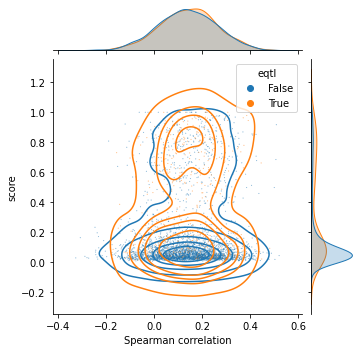

In [64]:
g = sns.jointplot(
    x="corr", y="score", hue="eqtl", data=df,
    kind="kde", height=5,
    joint_kws=dict(common_norm=False, levels=6),
    marginal_kws=dict(common_norm=False, fill=True)
).plot_joint(sns.scatterplot, s=1, edgecolor=None, alpha=0.5, rasterized=True)
g.ax_joint.set_xlabel("Spearman correlation")
g.ax_joint.set_ylabel("score")
g.ax_joint.get_legend().set_title("eqtl")
g.fig.savefig(f"{PATH}/corr_score_pchic.pdf")

# 10. ROC Analysis and Method Comparison

## Purpose
Compare the performance of different methods using ROC curves and AUROC scores against eQTL validation data.

## Performance Metrics
- **AUROC**: Area Under Receiver Operating Characteristic curve
- **Method Comparison**: Direct comparison of MultiGATE vs traditional approaches
- **eQTL Validation**: Use known eQTL associations as ground truth for evaluation


In [65]:
df

,corr,dist,Gene,Peak,eqtl,regr,cicero,chrom,start1,end1,Chrm1,Start1,End1,Chrm2,Start2,End2,score,distance,dist_bin
0,0.041985,87163,PPFIA1,chr11:70180734-70181537,False,-0.000000,0.000000,chr11,70180734,70181537,chr11,70270699,70384403,chr11,70180734,70181537,0.033956,89965,75-100 kb
1,0.353153,0,PPFIA1,chr11:70270217-70271079,False,-0.000000,0.000000,chr11,70270217,70271079,chr11,70270699,70384403,chr11,70270217,70271079,0.825644,482,0-25 kb
2,0.070612,10355,PPFIA1,chr11:70281054-70281902,False,-0.010369,0.000000,chr11,70281054,70281902,chr11,70270699,70384403,chr11,70281054,70281902,0.204230,10355,0-25 kb
3,-0.025379,113756,PPFIA1,chr11:70384455-70385310,False,0.000000,0.000000,chr11,70384455,70385310,chr11,70270699,70384403,chr11,70384455,70385310,0.025811,113756,100-125 kb
4,0.235320,127305,PPFIA1,chr11:70398004-70398847,False,-0.056503,0.000000,chr11,70398004,70398847,chr11,70270699,70384403,chr11,70398004,70398847,0.022194,127305,125-150 kb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3741,0.125040,0,MIPEP,chr13:23888975-23889801,True,0.010933,0.000000,chr13,23888975,23889801,chr13,23730188,23889419,chr13,23888975,23889801,0.817036,158787,NaN
3742,0.107152,88032,MIPEP,chr13:23979450-23980037,False,-0.060284,0.118561,chr13,23979450,23980037,chr13,23730188,23889419,chr13,23979450,23980037,0.178357,249262,NaN
3743,0.091456,101176,MIPEP,chr13:23992594-23993519,False,0.018701,0.079008,chr13,23992594,23993519,chr13,23730188,23889419,chr13,23992594,23993519,0.074658,262406,NaN
3744,0.065928,147112,MIPEP,chr13:24038530-24039306,False,-0.127989,0.000000,chr13,24038530,24039306,chr13,23730188,23889419,chr13,24038530,24039306,0.066024,308342,NaN


In [66]:
import utils

In [67]:
def boxplot(x=None, y=None, hue=None, data=None, bins_factor=2):
    """
    Box plot with marginal frequency distribution histogram
    """
    # Ensure the specified columns exist in the DataFrame
    assert x in data and y in data and hue in data

    # Make a copy of the DataFrame to avoid modifying the original data
    plot_data = data.copy(deep=False)

    # Convert columns to appropriate data types
    if not pd.api.types.is_categorical_dtype(plot_data[x]):
        plot_data[x] = plot_data[x].astype("category")
    if not pd.api.types.is_categorical_dtype(plot_data[hue]):
        plot_data[hue] = plot_data[hue].astype("category")
    plot_data[y] = plot_data[y].astype(float)

    # Create the JointGrid instance
    g = sns.JointGrid(x=x, y=y, data=plot_data, height=5)
    # Hide the right y-axis
    # g.ax_joint.yaxis.set_visible(False)
    g.ax_marg_y.set_visible(False)
    print(g.ax_joint)
    # Boxplot on joint
    sns.boxplot(
        x=x, y=y, hue=hue, data=plot_data,
        saturation=1.0, showmeans=True,
        meanprops=dict(marker="^", markerfacecolor="white", markeredgecolor="black"),
        boxprops=dict(edgecolor="black"), medianprops=dict(color="black"),
        whiskerprops=dict(color="black"), capprops=dict(color="black"),
        flierprops=dict(marker=".", markerfacecolor="black", markeredgecolor="none", markersize=3),
        ax=g.ax_joint
    )


    # Group data by 'x' and 'hue' columns and calculate fractions
    # grouped_data = plot_data.groupby([x, hue])[y].size().groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index(name='frac')
    grouped_data = plot_data.groupby([x, hue])[y].size().groupby(level=0).apply(lambda x: x / float(x.sum())).reset_index(name='frac')

    # Initialize bottom array for the stacked bar chart
    bottom = np.zeros(len(plot_data[x].cat.categories))

    # Loop through each level of the hue and plot the bars
    for name, group in grouped_data.groupby(hue):
        g.ax_marg_x.bar(group[x], group['frac'], bottom=bottom, label=name, width=0.7, edgecolor="black")
        bottom += group['frac'].values

    # Add a legend if there are hue levels
    if len(plot_data[hue].cat.categories) > 1:
        g.ax_marg_x.legend(title=hue)

    return g


AxesSubplot(0.132778,0.118628;0.693698x0.705422)


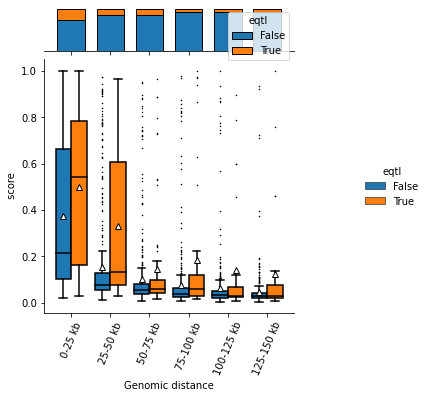

In [68]:
g = boxplot(x="dist_bin", y="score", hue='eqtl', data=df)
g.ax_joint.legend(loc="center left", bbox_to_anchor=(1.25, 0.5), frameon=False, title="eqtl")
g.ax_joint.set_xlabel("Genomic distance")
g.ax_joint.set_ylabel(" score")
for item in g.ax_joint.get_xticklabels():
    item.set_rotation(67.5)
g.savefig(f"{PATH}/dist_binned_score_pchic.pdf")

In [69]:
PATH

'results_eqtl_only_20250613'

In [70]:
df.columns


Index(['corr', 'dist', 'Gene', 'Peak', 'eqtl', 'regr', 'cicero', 'chrom',
       'start1', 'end1', 'Chrm1', 'Start1', 'End1', 'Chrm2', 'Start2', 'End2',
       'score', 'distance', 'dist_bin'],
      dtype='object')

In [71]:
import plot

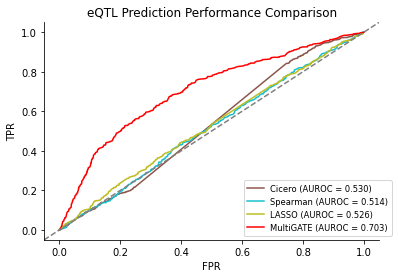

In [72]:
# Calculate AUROC scores for all methods
cicero_auroc = sklearn.metrics.roc_auc_score(df["eqtl"].astype(bool), df["cicero"])
corr_auroc = sklearn.metrics.roc_auc_score(df["eqtl"].astype(bool), df["corr"])
regr_auroc = sklearn.metrics.roc_auc_score(df["eqtl"].astype(bool), df["regr"])
our_auroc = sklearn.metrics.roc_auc_score(df["eqtl"].astype(bool), df["score"])

# Generate ROC curve comparison plot
fig, ax = plt.subplots()
ax = plot.roc(df["eqtl"].astype(bool), df["cicero"], label=f"Cicero (AUROC = {cicero_auroc:.3f})", color=palette["Cicero"])
ax = plot.roc(df["eqtl"].astype(bool), df["corr"], label=f"Spearman (AUROC = {corr_auroc:.3f})", color=palette["Spearman"], ax=ax)
ax = plot.roc(df["eqtl"].astype(bool), df["regr"], label=f"LASSO (AUROC = {regr_auroc:.3f})", color=palette["LASSO"], ax=ax)
ax= plot.roc(df["eqtl"].astype(bool), df["score"], label=f"MultiGATE (AUROC = {our_auroc:.3f})", color="red", ax=ax)

# Customize plot appearance
ax.set_title("eQTL Prediction Performance Comparison")
ax.axline((0, 0), (1, 1), ls="--", c="grey")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend(loc="lower right", bbox_to_anchor=(1.05, 0.0), fontsize="small", frameon=True)
fig.savefig(f"{PATH}/eqtl_roc.pdf")
plt.show()

# Summary and Conclusions

## Analysis Results
This notebook compared MultiGATE's cross-modality attention scores against three established methods for cis-regulatory prediction:

1. **Spearman Correlation**: Expression-accessibility correlation analysis
2. **LASSO Regression**: Sparse linear regression with L1 regularization  
3. **Cicero**: Chromatin co-accessibility based predictions

## Performance Evaluation
All methods were evaluated using:
- **eQTL validation data** as ground truth for regulatory relationships
- **AUROC scores** for quantitative performance comparison
- **Distance-binned analysis** to understand genomic distance effects

## Key Findings
The ROC analysis provides quantitative comparison of method performance for predicting known eQTL associations, enabling assessment of MultiGATE's cross-modality attention mechanism relative to traditional approaches.
